# Antarctic Passive Tracers

This notebook plot some simple examples of the evolution of passive tracers from AABW formation regions. Still a work in progress ...

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
#from celluloid import Camera
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42131 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.36 GB


In [3]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

#### The IAF run is still in progress, so I have to make my own database.

Here is code to update database for latest IAF simulations. Warning -- this will take a while on the first time through.

In [4]:
dir_list = ['/scratch/v45/aek156/access-om2/archive/01deg_jra55v140_iaf_cycle3']
cc.database.build_index(dir_list, session, update=True)

Indexing experiment: 01deg_jra55v140_iaf_cycle3


100%|██████████| 382/382 [02:06<00:00,  3.02it/s]


382

#### Load bathymetry information.

In [4]:
kmt = cc.querying.getvar(expt,'kmt',session, n=-1).fillna(1.0).astype(int) - 1
kmt.load()
ht = cc.querying.getvar(expt, 'ht', session,n=-1)

#### Loading last time frame from each tracer.

In [18]:
ross = cc.querying.getvar(expt,'passive_ross', session,frequency='1 monthly')
ross = ross.isel(time=-1)
ross.load()
bottom_ross = ross.isel(st_ocean=kmt)
surface_ross = ross.isel(st_ocean=0)

In [9]:
weddell = cc.querying.getvar(expt,'passive_weddell' , session,frequency='1 monthly')
weddell = weddell.isel(time=-1)
weddell.load()
bottom_weddell = weddell.isel(st_ocean=kmt)
surface_weddell = weddell.isel(st_ocean=0)

In [10]:
prydz = cc.querying.getvar(expt,'passive_prydz' , session,frequency='1 monthly')
prydz = prydz.isel(time=-1)
prydz.load()
bottom_prydz = prydz.isel(st_ocean=kmt)
surface_prydz = prydz.isel(st_ocean=0)

In [11]:
adelie = cc.querying.getvar(expt,'passive_adelie' , session,frequency='1 monthly')
adelie = adelie.isel(time=-1)
adelie.load()
bottom_adelie = adelie.isel(st_ocean=kmt)
surface_adelie = adelie.isel(st_ocean=0)

#### Plot on south polar stereographic projection with circular cutout

In [12]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons,lats):
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

In [13]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

#### Plotting all four tracers on one map

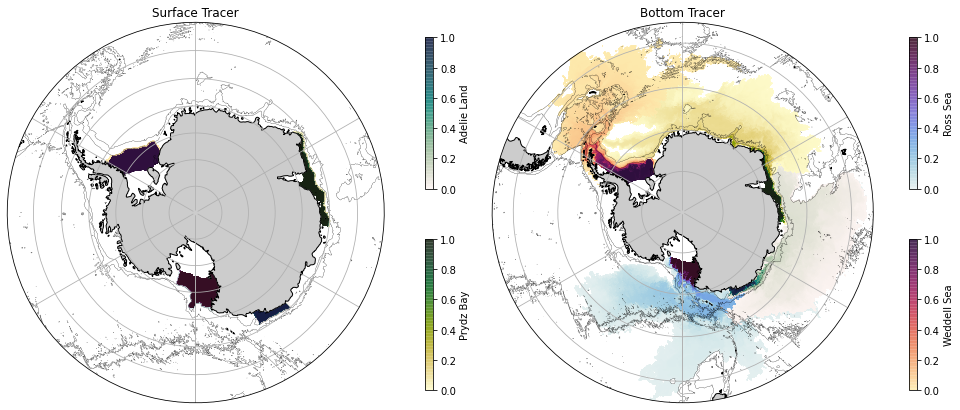

In [19]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1r = surface_ross.where(surface_ross>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.dense,transform=ccrs.PlateCarree())
p1a = surface_adelie.where(surface_adelie>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.tempo,transform=ccrs.PlateCarree())
p1p = surface_prydz.where(surface_prydz>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.speed,transform=ccrs.PlateCarree())
p1w = surface_weddell.where(surface_weddell>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.matter,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Surface Tracer')

ax = plt.subplot(1, 2, 2, projection=projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

p2r = bottom_ross.where(bottom_ross>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.dense,transform=ccrs.PlateCarree())
p2a = bottom_adelie.where(bottom_adelie>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.tempo,transform=ccrs.PlateCarree())
p2p = bottom_prydz.where(bottom_prydz>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.speed,transform=ccrs.PlateCarree())
p2w = bottom_weddell.where(bottom_weddell>0.01,np.NaN).plot(add_colorbar=False,vmin=0,vmax=1.0,alpha=0.5,cmap=cm.cm.matter,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Bottom Tracer')

ax_cb = plt.axes([0.92, 0.55, 0.007, 0.3])
cb = plt.colorbar(p2r,cax=ax_cb, orientation='vertical')
cb.set_label('Ross Sea')

ax_cb = plt.axes([0.92, 0.15, 0.007, 0.3])
cb = plt.colorbar(p2w,cax=ax_cb, orientation='vertical')
cb.set_label('Weddell Sea')

ax_cb = plt.axes([0.5, 0.15, 0.007, 0.3])
cb = plt.colorbar(p2p,cax=ax_cb, orientation='vertical')
cb.set_label('Prydz Bay')

ax_cb = plt.axes([0.5, 0.55, 0.007, 0.3])
cb = plt.colorbar(p2a,cax=ax_cb, orientation='vertical')
cb.set_label('Adelie Land')

plt.savefig('TracerConcentrationMap.png',dpi=250,facecolor='w')

**There is too much overlap between tracers here.** I haven't figured out how to make the contour maps transparent to each other. Will have to divide them up. However, this plot does show that, at the surface, restoring has acted to limit tracer just to the pre-defined regions.

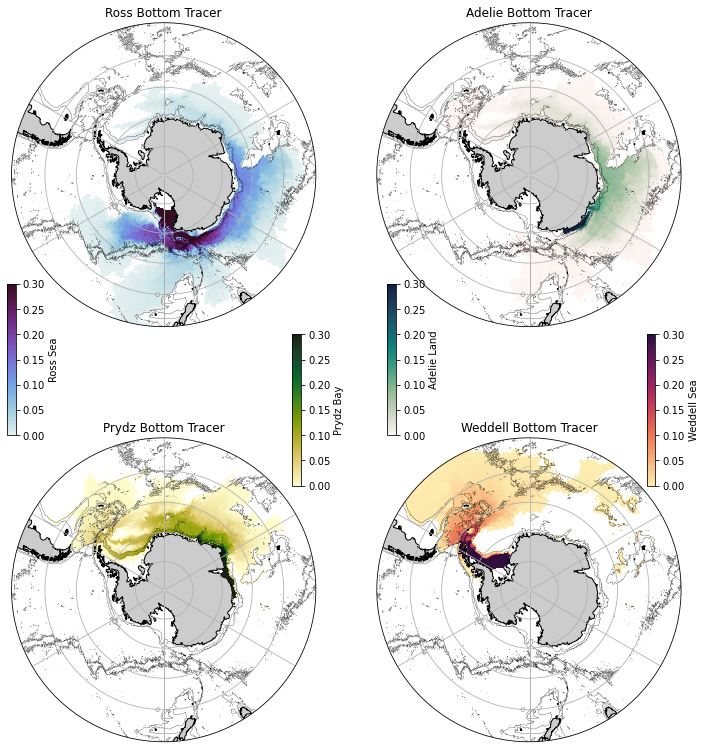

In [20]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(12, 14))
ax = plt.subplot(2, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p2r = bottom_ross.where(bottom_ross>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.3,cmap=cm.cm.dense,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Ross Bottom Tracer')

ax = plt.subplot(2, 2, 2, projection=projection)
ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

p2a = bottom_adelie.where(bottom_adelie>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.3,cmap=cm.cm.tempo,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Adelie Bottom Tracer')

ax = plt.subplot(2, 2, 3, projection=projection)
ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

p2p = bottom_prydz.where(bottom_prydz>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.3,cmap=cm.cm.speed,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Prydz Bottom Tracer')

ax = plt.subplot(2, 2, 4, projection=projection)
ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_boundary(circle, transform=ax.transAxes)

p2w = bottom_weddell.where(bottom_weddell>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.3,cmap=cm.cm.matter,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Weddell Bottom Tracer')


ax_cb = plt.axes([0.12, 0.45, 0.01, 0.15])
cb = plt.colorbar(p2r,cax=ax_cb, orientation='vertical')
cb.set_label('Ross Sea')

ax_cb = plt.axes([0.56, 0.45, 0.01, 0.15])
cb = plt.colorbar(p2a,cax=ax_cb, orientation='vertical')
cb.set_label('Adelie Land')


ax_cb = plt.axes([0.45, 0.4, 0.01, 0.15])
cb = plt.colorbar(p2p,cax=ax_cb, orientation='vertical')
cb.set_label('Prydz Bay')

ax_cb = plt.axes([0.86, 0.4, 0.01, 0.15])
cb = plt.colorbar(p2w,cax=ax_cb, orientation='vertical')
cb.set_label('Weddell Sea')


plt.savefig('TracerConcentrationMap4.png',dpi=250,facecolor='w')

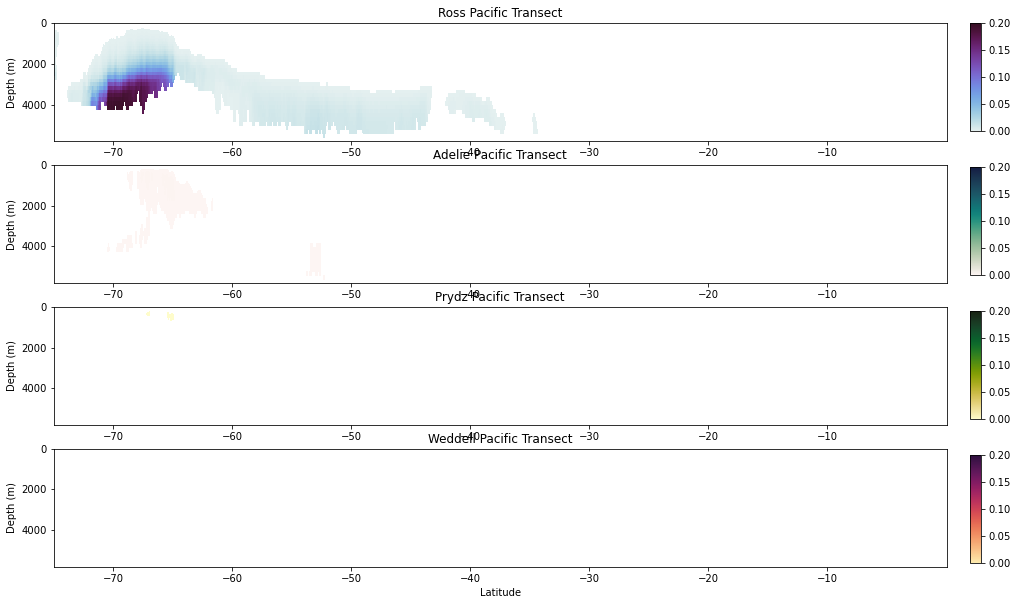

In [21]:
plt.figure(figsize=(16,10))

longitude = -170


plt.subplot(411)
pacific_ross = ross.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppr = pacific_ross.where(pacific_ross>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.dense)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Ross Pacific Transect')

ax_cb = plt.axes([0.92, 0.73, 0.01, 0.15])
cb = plt.colorbar(ppr,cax=ax_cb, orientation='vertical')

plt.subplot(412)
pacific_adelie = adelie.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppa=pacific_adelie.where(pacific_adelie>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.tempo)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Adelie Pacific Transect')

ax_cb = plt.axes([0.92, 0.53, 0.01, 0.15])
cb = plt.colorbar(ppa,cax=ax_cb, orientation='vertical')

plt.subplot(413)
pacific_prydz = prydz.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppp = pacific_prydz.where(pacific_prydz>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.speed)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Prydz Pacific Transect')


ax_cb = plt.axes([0.92, 0.33, 0.01, 0.15])
cb = plt.colorbar(ppp,cax=ax_cb, orientation='vertical')

plt.subplot(414)
pacific_weddell = weddell.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppw = pacific_weddell.where(pacific_weddell>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.matter)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Weddell Pacific Transect')

ax_cb = plt.axes([0.92, 0.13, 0.01, 0.15])
cb = plt.colorbar(ppw,cax=ax_cb, orientation='vertical')

plt.savefig('TracerTransectsPacific.png',dpi=250)

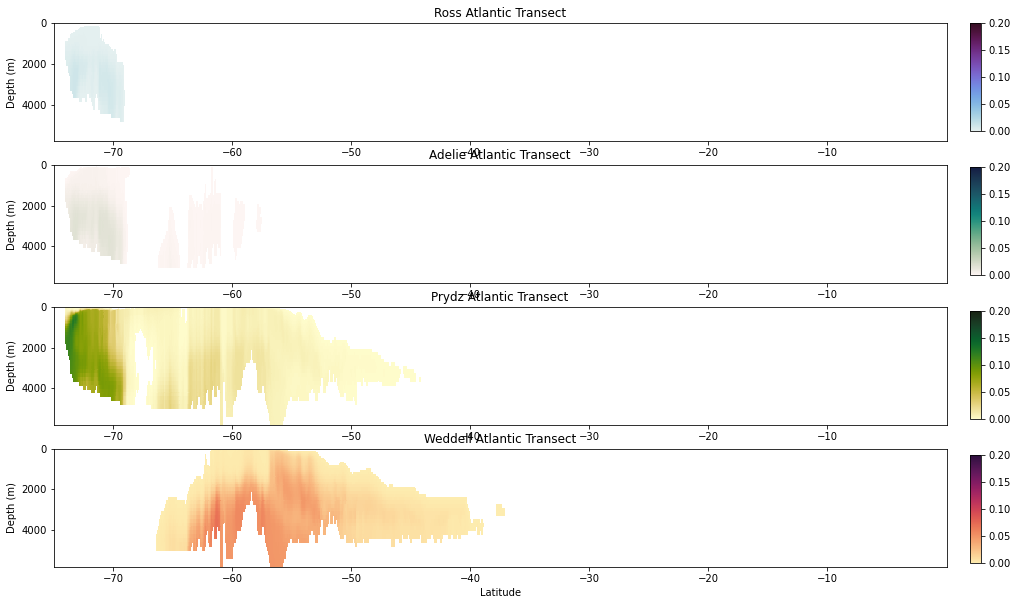

In [22]:
plt.figure(figsize=(16,10))
longitude = -25

plt.subplot(411)
atlantic_ross = ross.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppr = atlantic_ross.where(atlantic_ross>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.dense)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Ross Atlantic Transect')

ax_cb = plt.axes([0.92, 0.73, 0.01, 0.15])
cb = plt.colorbar(ppr,cax=ax_cb, orientation='vertical')

plt.subplot(412)
atlantic_adelie = adelie.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppa=atlantic_adelie.where(atlantic_adelie>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.tempo)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Adelie Atlantic Transect')

ax_cb = plt.axes([0.92, 0.53, 0.01, 0.15])
cb = plt.colorbar(ppa,cax=ax_cb, orientation='vertical')

plt.subplot(413)
atlantic_prydz = prydz.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppp = atlantic_prydz.where(atlantic_prydz>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.speed)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Prydz Atlantic Transect')


ax_cb = plt.axes([0.92, 0.33, 0.01, 0.15])
cb = plt.colorbar(ppp,cax=ax_cb, orientation='vertical')

plt.subplot(414)
atlantic_weddell = weddell.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppw = atlantic_weddell.where(atlantic_weddell>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.matter)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Weddell Atlantic Transect')

ax_cb = plt.axes([0.92, 0.13, 0.01, 0.15])
cb = plt.colorbar(ppw,cax=ax_cb, orientation='vertical')

plt.savefig('TracerTransectsAtlantic.png',dpi=250)

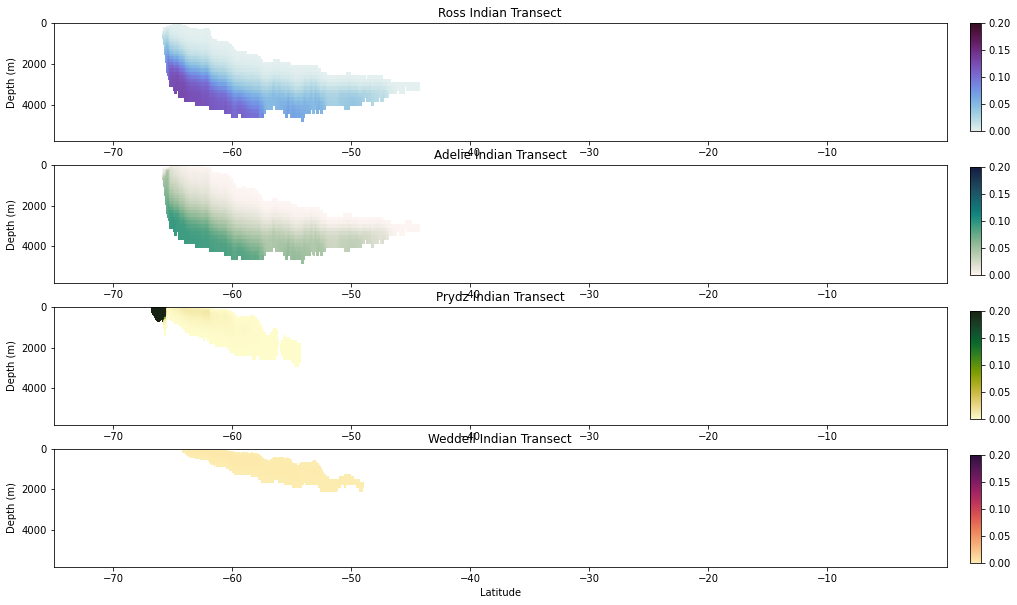

In [23]:
plt.figure(figsize=(16,10))
longitude = -270

plt.subplot(411)
indian_ross = ross.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppr = indian_ross.where(indian_ross>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.dense)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Ross Indian Transect')

ax_cb = plt.axes([0.92, 0.73, 0.01, 0.15])
cb = plt.colorbar(ppr,cax=ax_cb, orientation='vertical')

plt.subplot(412)
indian_adelie = adelie.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppa=indian_adelie.where(indian_adelie>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.tempo)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Adelie Indian Transect')

ax_cb = plt.axes([0.92, 0.53, 0.01, 0.15])
cb = plt.colorbar(ppa,cax=ax_cb, orientation='vertical')

plt.subplot(413)
indian_prydz = prydz.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppp = indian_prydz.where(indian_prydz>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.speed)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('Prydz Indian Transect')


ax_cb = plt.axes([0.92, 0.33, 0.01, 0.15])
cb = plt.colorbar(ppp,cax=ax_cb, orientation='vertical')

plt.subplot(414)
indian_weddell = weddell.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=slice(-75,-0))
ppw = indian_weddell.where(indian_weddell>0.001,np.NaN).plot(add_colorbar=False,vmin=0,vmax=0.2,cmap=cm.cm.matter)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Weddell Indian Transect')

ax_cb = plt.axes([0.92, 0.13, 0.01, 0.15])
cb = plt.colorbar(ppw,cax=ax_cb, orientation='vertical')

plt.savefig('TracerTransectsIndian.png',dpi=250)

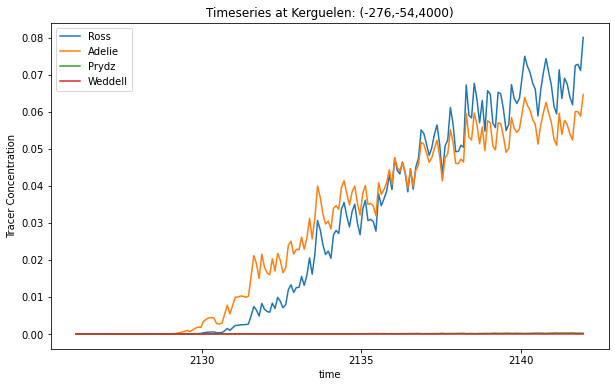

In [24]:
plt.figure(figsize=(10,6))

latitude = -54
longitude=-276
depth=4000

ross = cc.querying.getvar(expt,'passive_ross' , session,frequency='1 monthly')
ross.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Ross')

adelie = cc.querying.getvar(expt,'passive_adelie' , session,frequency='1 monthly')
adelie.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Adelie')

prydz = cc.querying.getvar(expt,'passive_prydz' , session,frequency='1 monthly')
prydz.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Prydz')

weddell = cc.querying.getvar(expt,'passive_weddell' , session,frequency='1 monthly')
weddell.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Weddell')

plt.legend()
plt.ylabel('Tracer Concentration')
plt.title('Timeseries at Kerguelen: ('+str(longitude)+','+str(latitude)+','+str(depth)+')')

plt.savefig('TracerConcentrationTimeseriesKerguelen.png',dpi=250)

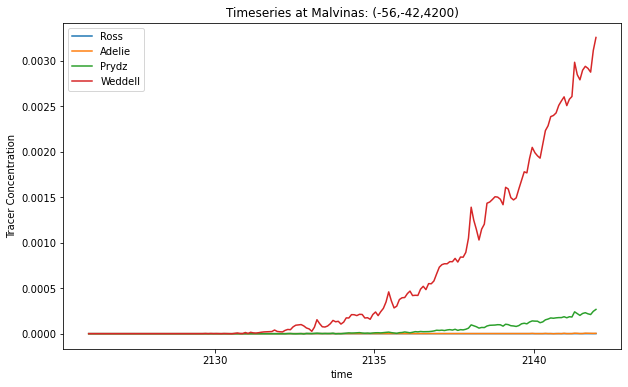

In [25]:
plt.figure(figsize=(10,6))

latitude = -42
longitude=-56
depth=4200

ross = cc.querying.getvar(expt,'passive_ross' , session,frequency='1 monthly')
ross.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Ross')

adelie = cc.querying.getvar(expt,'passive_adelie' , session,frequency='1 monthly')
adelie.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Adelie')

prydz = cc.querying.getvar(expt,'passive_prydz' , session,frequency='1 monthly')
prydz.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Prydz')

weddell = cc.querying.getvar(expt,'passive_weddell' , session,frequency='1 monthly')
weddell.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Weddell')

plt.legend()
plt.ylabel('Tracer Concentration')
plt.title('Timeseries at Malvinas: ('+str(longitude)+','+str(latitude)+','+str(depth)+')')

plt.savefig('TracerConcentrationTimeseriesMalvinas.png',dpi=250)

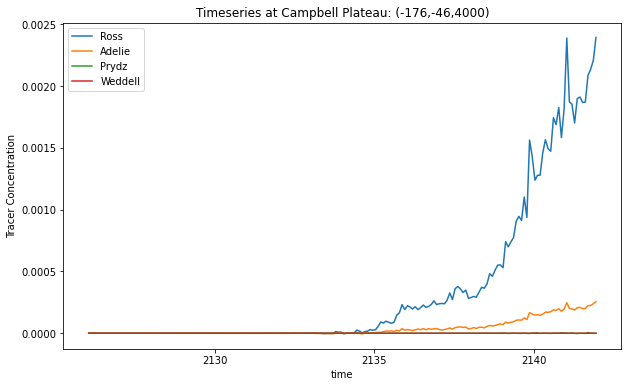

In [26]:
plt.figure(figsize=(10,6))

latitude = -46
longitude=-176
depth=4000

ross = cc.querying.getvar(expt,'passive_ross' , session,frequency='1 monthly')
ross.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Ross')

adelie = cc.querying.getvar(expt,'passive_adelie' , session,frequency='1 monthly')
adelie.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Adelie')

prydz = cc.querying.getvar(expt,'passive_prydz' , session,frequency='1 monthly')
prydz.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Prydz')

weddell = cc.querying.getvar(expt,'passive_weddell' , session,frequency='1 monthly')
weddell.sel(xt_ocean=longitude,method='nearest').sel(yt_ocean=latitude,method='nearest').sel(st_ocean=depth,method='nearest').plot(label='Weddell')

plt.legend()
plt.ylabel('Tracer Concentration')
plt.title('Timeseries at Campbell Plateau: ('+str(longitude)+','+str(latitude)+','+str(depth)+')')

plt.savefig('TracerConcentrationTimeseriesCampbell.png',dpi=250)